# Inline-Hologram Reconstruction
This Notebook should recover a hologram recorded with an inline holographical microscope

In [1]:
# manage the imports
%load_ext autoreload
%reload_ext autoreload

#iPython related imports and settings
from ipywidgets import interact, widgets, fixed
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib.pyplot as plt
import os
import time
# Inline matplotlib and costume image size
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Define the fresnel propagator

In [2]:
def abssqr(x):
    # this is what a detector sees (only intensities)
    return np.real(x*np.conj(x))

def FT(x):
    # this only defines the correct fwd fourier transform including proper shift of the frequencies
    return np.fft.fftshift(np.fft.fft2(x)) # Fourier transform and shift

def iFT(x):
    # this only defines the correct inverse fourier transform including proper shift of the frequencies
    return np.fft.ifft2(np.fft.ifftshift(x)) # inverse Fourier transform and shift
    
def FresnelPropagator(E0, ps, lambda0, z):
    # Freespace propagation using Fresnel-kernel
    #
    # Inputs: 
    #             E0 - initial complex field in x-y source plane
    #             ps - pixel size in microns
    #             lambda0 - wavelength in nm
    #             z - z-value (distance from sensor to object)
    #             background - optional background image to divide out from
    #                
    # Outputs:
    #             Ef - Propagated output-field
    #             H - Fresnel Kernel
    
    upsample_scale = 1;                 # Scale by which to upsample image
    n = upsample_scale * E0.shape[1] # Image width in pixels (same as height)
    grid_size = ps * n;                 # Grid size in x-direction
    

    # Inverse space
    fx = np.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    fy = np.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    Fx, Fy = np.meshgrid(fx, fy)
    
    # Fresnel kernel / point spread function h = H(kx, ky)
    # from Fourier Optics, chapter 4
    # H = sqrt(z*lambda0)*exp(1i*pi*lambda0*z*(Fx.^2+Fy.^2));
    # sphere=exp(i*k/2/zc*(xx.^2+yy.^2));
    H = np.exp(1j*(2 * np.pi / lambda0) * z) * np.exp(1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    #H= cos(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0)+1i.*sin(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0);
    
    # Compute FFT centered about 0
    E0fft = FT((E0));     # Centered about 0 since fx and fy centered about 0
    
    # Multiply spectrum with fresnel phase-factor
    G = H * E0fft
    Ef = iFT(G) # Output after deshifting Fourier transform
    
    return Ef#, H

## Define experimental parameters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [14.0..255.0].


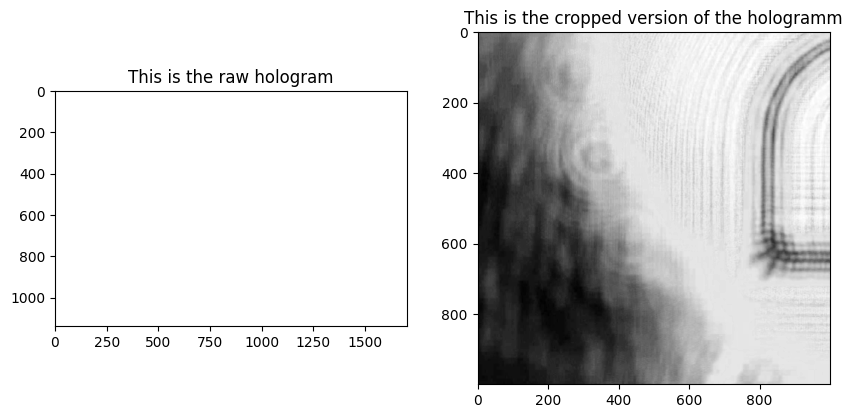

In [25]:
# define some experimental parameters
my_background_file = 'testholo.jpg'#'test2bg.jpg'
my_holo_file = "/Users/bene/MVS_Data/Data/Image_20250212190004900.bmp"
my_holo_file = "/Users/bene/Downloads/Holo3.jpg"
mychannel = 2 # select the color channel 0,1,2
mysize = 1024 # region of interest around the center coordinate 
center_x = 700 # This is the center where we want to crop the ROI of the holgrom 
center_y = 700 # This is the center where we want to crop the ROI of the holgrom 


# define acquisition parameters
pixelsize = 1.4e-6; #0.6e-6#.2e-6#3.000e-6;
lambda0 = 440e-9; # in nanometer #530e-9;

# start and stop z-focus measure
stepsize = 0.001;

# read the raw-hologram
myholo = 1.*plt.imread(my_holo_file);
                      
# select only the blue channel (because we used the blue LED)                     
#myholo = myholo[:,:,mychannel ]

# if we acquired the background, subtract it! 
if(0):
    mybak = 1.*imread(my_background_file)
    mybak = mybak[:,:,mychannel ]
    myholo = myholo/(20+mybak) # add some value to avoid dividing by zero

# Display the raw hologram
plt.subplot(121)
plt.title('This is the raw hologram'), 
plt.imshow(myholo)
# crop out the ROI around the center to speed up computation (RADIX 2 please!)
holosize = myholo.shape
#myholo =  myholo[int(holosize[0]/2-mysize/2):int(holosize[0]/2+mysize/2), int(holosize[0]/2-mysize/2):int(holosize[0]/2+mysize/2)]
myholo =  myholo[:1000,:1000,0]


# display intermediate result 
plt.subplot(122)
plt.imshow(myholo, cmap="gray")
plt.title("This is the cropped version of the hologramm")
#plt.colorbar()
plt.show()

# normalize hologram
myholo = myholo/np.max(myholo);

# estimate hologram's amplitude
myamplitude = np.sqrt(myholo); 


## Process the Holograms

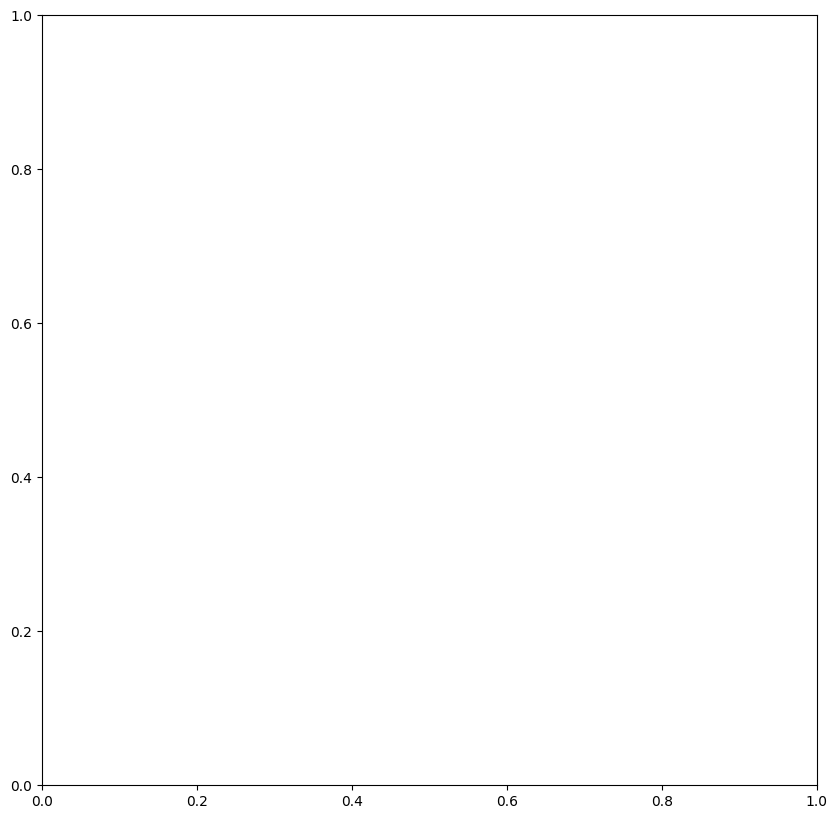

In [26]:
!pip install -q ipywidgets
import ipywidgets as widgets
j = 0;
## Backpropagate the Hologram
# Fresnel Propagation - test out a range of z-values to find the one that
# brings the bug into focus
# Inspired from: https://stackoverflow.com/questions/48335240/change-content-of-image-interactively-using-slider-widgets
def FPfocus(myholo, pixelsize, lambda0, zpos):
    Ef = FresnelPropagator(myholo, pixelsize, lambda0, zpos)
    If = abssqr(Ef)
    ax_new.imshow(If, cmap="gray")
    fig.canvas.draw()
    display(fig)
    print("Now processed z-slice at z-position (mum) "+str(zpos))

# Creating costume widget
FocusSlider = widgets.FloatSlider(
    min = 0.001,
    max = 0.009,
    step = 0.0001,
    value=0,
    description = 'ZPos',
    continuous_update = True
)

# Generate a display
fig = plt.figure(figsize=(10, 10))
ax_new = fig.add_subplot(111) 
#ax_new = fig.add_subplot(122)

#ax_orig.imshow(myholo, cmap="gray")
#ax_new.imshow(myholo, cmap="gray")


# Refocussing of the hologram
Simpyl move the slider and digitally refocus the hologram. It may take some time as the computation is done online. 

In [27]:
# start interactive viewer
%matplotlib inline
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML


w = interactive(FPfocus, myholo=fixed(myholo), pixelsize=fixed(pixelsize), lambda0=fixed(lambda0), zpos=FocusSlider)
display(w)


# interact(FPfocus, myholo=fixed(myholo), pixelsize=fixed(pixelsize), lambda0=fixed(lambda0), zpos=FocusSlider)

interactive(children=(FloatSlider(value=0.001, description='ZPos', max=0.009, min=0.001, step=0.0001), Output(…

# Save the best result

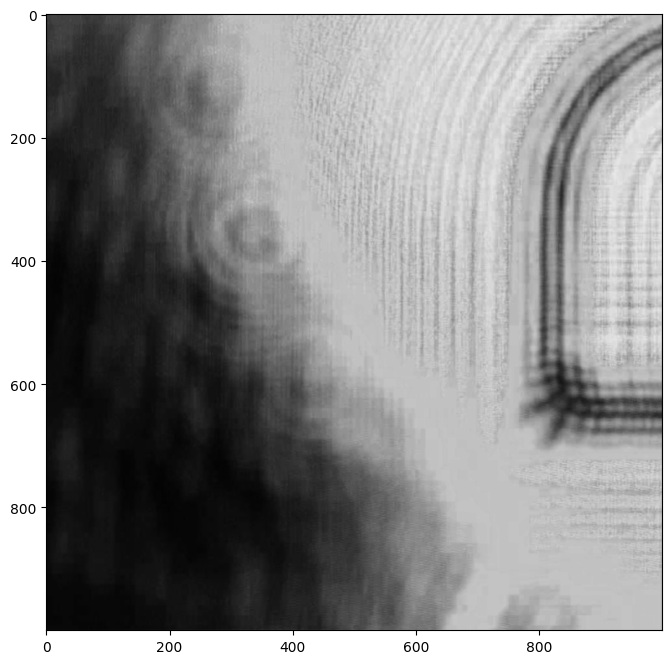

In [28]:
zpos = .00001
If = abssqr(FresnelPropagator(myholo, pixelsize, lambda0, zpos))
plt.imshow(If, cmap='gray')
plt.imsave('result.png',If)